In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import time
import math

In [72]:
# Load dataset
df = pd.read_csv('mushrooms.csv')
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [73]:
for col in df.columns:
    print(f"{col}: {list(df[col].unique())}")

class: ['p', 'e']
cap-shape: ['x', 'b', 's', 'f', 'k', 'c']
cap-surface: ['s', 'y', 'f', 'g']
cap-color: ['n', 'y', 'w', 'g', 'e', 'p', 'b', 'u', 'c', 'r']
bruises: ['t', 'f']
odor: ['p', 'a', 'l', 'n', 'f', 'c', 'y', 's', 'm']
gill-attachment: ['f', 'a']
gill-spacing: ['c', 'w']
gill-size: ['n', 'b']
gill-color: ['k', 'n', 'g', 'p', 'w', 'h', 'u', 'e', 'b', 'r', 'y', 'o']
stalk-shape: ['e', 't']
stalk-root: ['e', 'c', 'b', 'r', '?']
stalk-surface-above-ring: ['s', 'f', 'k', 'y']
stalk-surface-below-ring: ['s', 'f', 'y', 'k']
stalk-color-above-ring: ['w', 'g', 'p', 'n', 'b', 'e', 'o', 'c', 'y']
stalk-color-below-ring: ['w', 'p', 'g', 'b', 'n', 'e', 'y', 'o', 'c']
veil-type: ['p']
veil-color: ['w', 'n', 'o', 'y']
ring-number: ['o', 't', 'n']
ring-type: ['p', 'e', 'l', 'f', 'n']
spore-print-color: ['k', 'n', 'u', 'h', 'w', 'r', 'o', 'y', 'b']
population: ['s', 'n', 'a', 'v', 'y', 'c']
habitat: ['u', 'g', 'm', 'd', 'p', 'w', 'l']


Before applying PCA, we need to one-hot encode all of the categorical features. This is because we need numerical values in order to perform PCA. We choose one-hot encoding instead of arbitrarily assigning numbers to each class to prevent the algorithm from learning an ordinal relationship between the categories, allowing us to properly compute variance and correlations across features.

In [74]:
y = df['class']
X = df.drop('class', axis=1)
X = pd.get_dummies(X, drop_first=False) # Don't drop the first column when one-hot encoding

In [75]:
print(f"Before one-hot encoding, entire dataset: {df.shape}")
print(f"After one-hot encoding, input data: {X.shape}")

Before one-hot encoding, entire dataset: (8124, 23)
After one-hot encoding, input data: (8124, 117)


Now, we need to standardize the features. Even though they're already binary, standardization can still be useful. 
- It ensures that all categories are equally weighted
- Centering the mean to 0 also simplifies the cov matrix calculation

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Performing PCA:

In [77]:
cov_matrix = np.cov(X_scaled, rowvar=False)

In [78]:
cov_matrix

array([[ 1.00012311, -0.00538791, -0.19328401, ..., -0.09518932,
        -0.0528778 , -0.03776832],
       [-0.00538791,  1.00012311, -0.01767392, ..., -0.0089865 ,
        -0.00483516, -0.00345354],
       [-0.19328401, -0.01767392,  1.00012311, ...,  0.02189382,
         0.03063977, -0.01745167],
       ...,
       [-0.09518932, -0.0089865 ,  0.02189382, ...,  1.00012311,
        -0.08819496, -0.06299383],
       [-0.0528778 , -0.00483516,  0.03063977, ..., -0.08819496,
         1.00012311, -0.0338936 ],
       [-0.03776832, -0.00345354, -0.01745167, ..., -0.06299383,
        -0.0338936 ,  1.00012311]], shape=(117, 117))

In [79]:
# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort in descending order
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

In [80]:
# Project data onto principal components
X_pca = np.dot(X_scaled, eigenvectors)

# Explained variance ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

Plotting explained variance ratio and cumulative variance ratio:

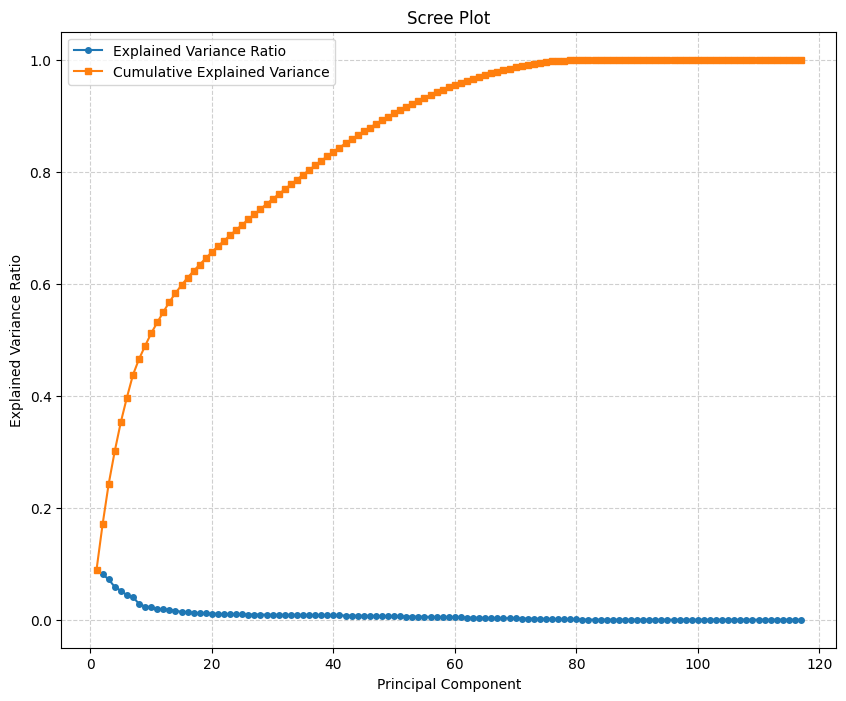

In [81]:
# Individual explained variance
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio,
         marker='o', ms=4, label='Explained Variance Ratio')

# Cumulative explained variance
plt.plot(np.arange(1, len(explained_variance_ratio) + 1),
         np.cumsum(explained_variance_ratio),
         marker='s', ms=4, label='Cumulative Explained Variance')

plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

To find the optimal number of components to keep, we'll aim for the min. no. of components to reach 95% variance:

In [82]:
# cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# find the smallest number of components where variance >= 95%
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Optimal number of components: {optimal_components}")

Optimal number of components: 59


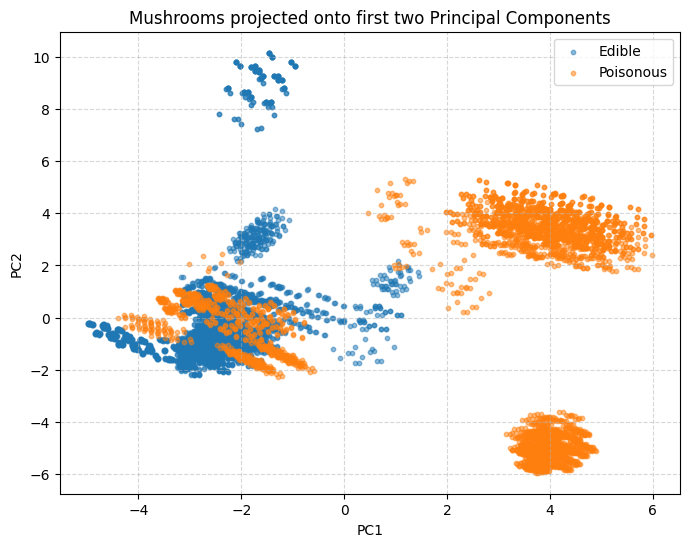

In [83]:
# Project onto first two PCs
X_pc2 = X_pca[:, :2]

# Scatter plot with class labels
plt.figure(figsize=(8,6))
plt.scatter(X_pc2[y == 'e', 0], X_pc2[y == 'e', 1], 
            alpha=0.5, label="Edible", s=10)
plt.scatter(X_pc2[y == 'p', 0], X_pc2[y == 'p', 1], 
            alpha=0.5, label="Poisonous", s=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Mushrooms projected onto first two Principal Components")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

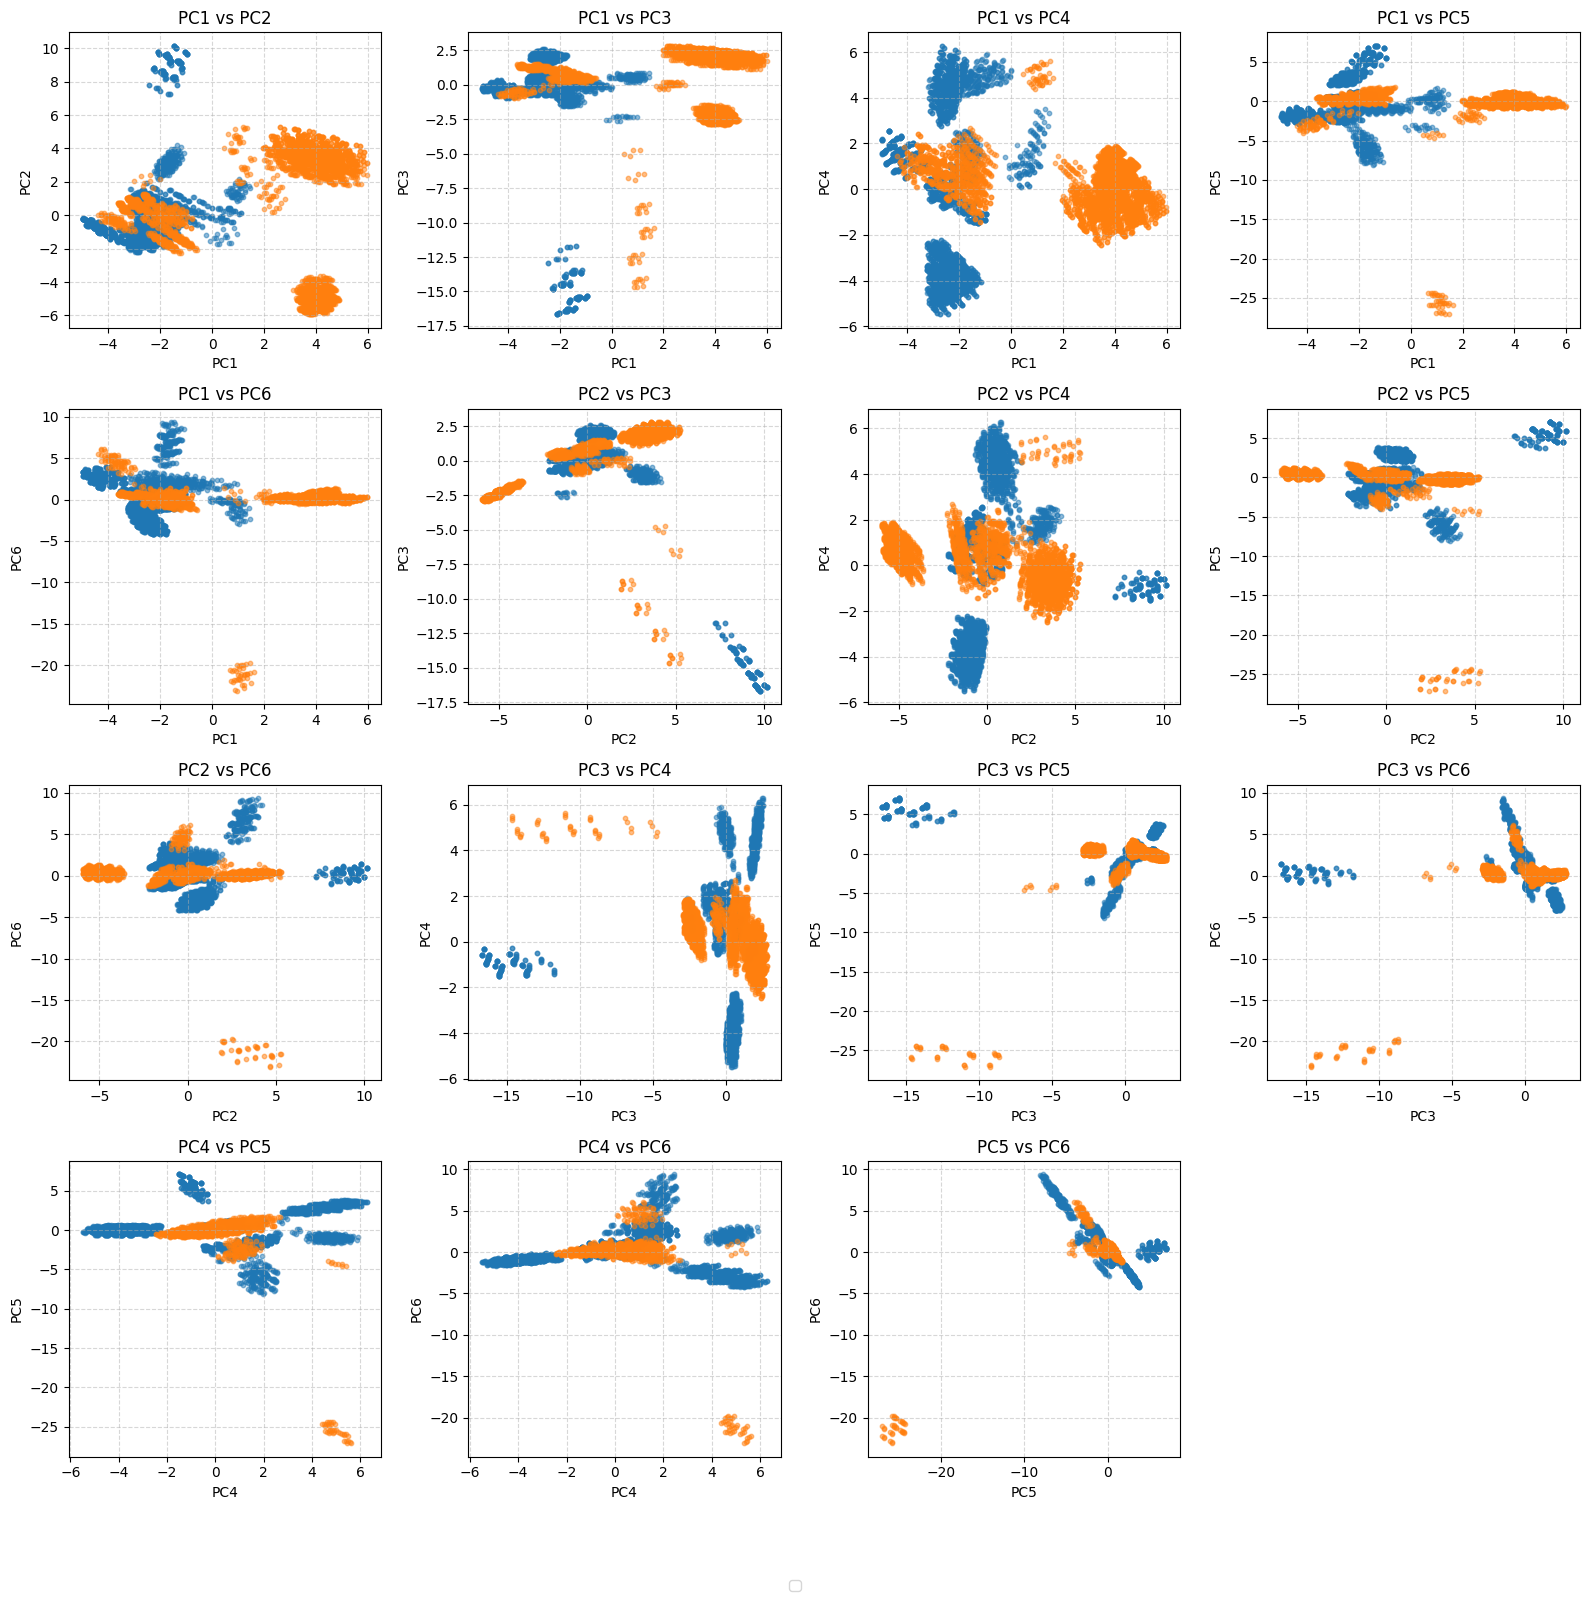

In [84]:
# Visualizing pair plots for the first 6 PCs
k = 6  # number of PCs to visualize
pairs = [(i, j) for i in range(k) for j in range(i+1, k)]

n_pairs = len(pairs)
n_cols = 4
n_rows = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

for ax, (i, j) in zip(axes.flat, pairs):
    ax.scatter(X_pca[y == 'e', i], X_pca[y == 'e', j],
               alpha=0.5, label="Edible", s=10)
    ax.scatter(X_pca[y == 'p', i], X_pca[y == 'p', j],
               alpha=0.5, label="Poisonous", s=10)
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.set_title(f"PC{i+1} vs PC{j+1}")
    ax.grid(True, linestyle='--', alpha=0.5)

# Hide any unused subplots
for ax in axes.flat[n_pairs:]:
    ax.set_visible(False)

# Put legend once at the bottom
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

From the plots, we can see the classes forming some distinct clusters for edible and poisonous mushrooms, but there is still some overlap between the two. They aren't fully linearly separable, but it's clear that the principal components are capturing features that distinguish the two. It's also clear that the higher-order PCs also reveal useful information and are needed to separate the two classes. 

In [85]:
# Split standardized data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [86]:
# Train logistic regression
lr = LogisticRegression(max_iter=500, solver='lbfgs')
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [87]:
# Predictions
y_pred = lr.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Misclassified:", round((1-acc) * len(y_test)), "out of", len(y_test))

Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 1.0
Misclassified: 0 out of 1625


We're able to classify the mushrooms into poisonous and edible with 100% accuracy with plain logistic regression

In [88]:
# Apply PCA with optimal components
pca = PCA(n_components=59)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# Train logistic regression on PCA-reduced data
lr_pca = LogisticRegression(max_iter=500, solver='lbfgs')
lr_pca.fit(X_train_pca, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [90]:
# Predictions
y_pred_pca = lr_pca.predict(X_test_pca)

# Evaluation
print("Classification Report (PCA-reduced):\n", classification_report(y_test, y_pred_pca))
acc = accuracy_score(y_test, y_pred_pca)
print("Accuracy (PCA-reduced):", acc)
print("Misclassified:", round((1-acc) * len(y_test)), "out of", len(y_test))

Classification Report (PCA-reduced):
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy (PCA-reduced): 0.9987692307692307
Misclassified: 2 out of 1625


Cross-validation

In [91]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Repeated CV: 5 folds, repeated 10 times = 50 runs total
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Original
cv_results_original = cross_validate(lr, X_scaled, y, cv=cv, scoring=scoring)

# PCA reduced
pca = PCA(n_components=59)
X_pca_59 = pca.fit_transform(X_scaled)
cv_results_pca = cross_validate(lr, X_pca_59, y, cv=cv, scoring=scoring)

# Display results
print("Original Data (Repeated 5-fold CV, 10 repeats):")
for metric in scoring:
    mean, std = np.mean(cv_results_original['test_' + metric]), np.std(cv_results_original['test_' + metric])
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

print("\nPCA-Reduced Data (59 PCs, Repeated 5-fold CV, 10 repeats):")
for metric in scoring:
    mean, std = np.mean(cv_results_pca['test_' + metric]), np.std(cv_results_pca['test_' + metric])
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

Original Data (Repeated 5-fold CV, 10 repeats):
accuracy: 1.0000 ± 0.0002
precision_macro: 1.0000 ± 0.0002
recall_macro: 0.9999 ± 0.0003
f1_macro: 1.0000 ± 0.0002

PCA-Reduced Data (59 PCs, Repeated 5-fold CV, 10 repeats):
accuracy: 0.9996 ± 0.0004
precision_macro: 0.9996 ± 0.0004
recall_macro: 0.9996 ± 0.0004
f1_macro: 0.9996 ± 0.0004


Performance analysis:

In [92]:
n_runs = 50
times_original, times_pca = [], []

for _ in range(n_runs):
    # Original data
    start = time.time()
    cross_validate(lr, X_scaled, y, cv=5, scoring=scoring)
    times_original.append(time.time() - start)

    # PCA data
    start = time.time()
    cross_validate(lr, X_pca_59, y, cv=5, scoring=scoring)
    times_pca.append(time.time() - start)

print(f"Original Data Avg Time: {np.mean(times_original):.4f} ± {np.std(times_original):.4f} sec")
print(f"PCA Data Avg Time: {np.mean(times_pca):.4f} ± {np.std(times_pca):.4f} sec")
print(f"Speedup: {np.mean(times_original) / np.mean(times_pca):.4f}")

Original Data Avg Time: 2.2980 ± 0.3881 sec
PCA Data Avg Time: 0.2942 ± 0.0445 sec
Speedup: 7.8119


In [93]:
size_original = X_scaled.nbytes / (1024**2)  # MB
size_pca = X_pca_59.nbytes / (1024**2)      # MB

print(f"Original feature matrix size: {size_original:.2f} MB")
print(f"PCA-reduced (59 PCs) size: {size_pca:.2f} MB")
print(f"Compression ratio: {size_pca / size_original:.2%}")

Original feature matrix size: 7.25 MB
PCA-reduced (59 PCs) size: 3.66 MB
Compression ratio: 50.43%


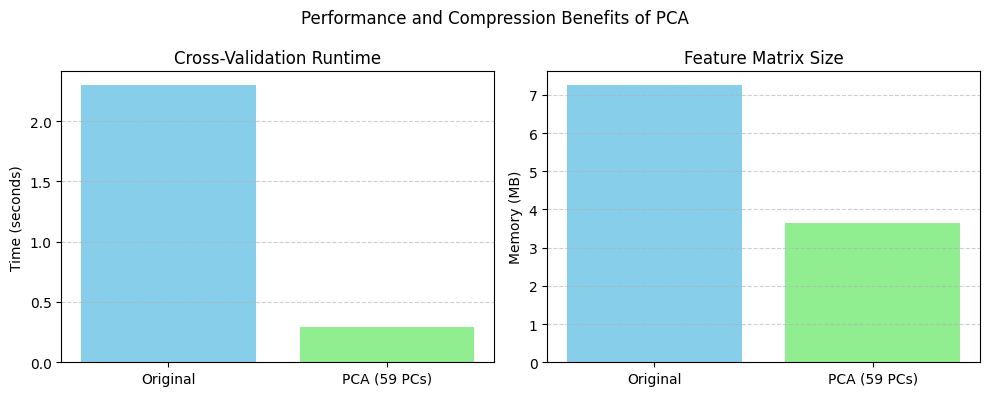

In [94]:
time_before = np.mean(times_original)
time_after = np.mean(times_pca)

size_before = size_original
size_after = size_pca

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Runtime comparison
axes[0].bar(["Original", "PCA (59 PCs)"], [time_before, time_after], color=["skyblue", "lightgreen"])
axes[0].set_title("Cross-Validation Runtime")
axes[0].set_ylabel("Time (seconds)")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# Data size comparison
axes[1].bar(["Original", "PCA (59 PCs)"], [size_before, size_after], color=["skyblue", "lightgreen"])
axes[1].set_title("Feature Matrix Size")
axes[1].set_ylabel("Memory (MB)")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Performance and Compression Benefits of PCA", fontsize=12)
plt.tight_layout()
plt.show()

## Comparison and Analysis

The original model attained a perfect score, but the PCA-reduced model only got a score of 99.96%, misclassifying 2 mushrooms out of the 1625 in the test set. The difference is not statistically significant - the standard deviations overlap, so no major performance difference between the two. But we can see that the PCA reduced model performs slightly worse on these splits. Overall, preserving the 59 components retained nearly all discriminative information.

But, in a real life scenario, I would think twice before relying on either model, considering the fact that eating a poisonous mushroom could be a fatal mistake. 

### Trade-offs
- Using the original data, we get slightly better results
- Performing PCA, although the results are slightly worse (negligible), there are still some benefits - the data is more compact, there's less collinearity, and the training is more efficient, taking only a fraction of the time

By performing PCA for this dataset, we get:
- An almost 7x speedup, and
- 50% compression, 

because of the reduced number of features. This means that we get faster training/cross-validation and a smaller memory footprint

### Logistic Regression as a Surrogate for PCA Evaluation
Since logistic regression uses a linear model, its performance will directly depend on how well PCA can project the data into a lower-dimensional, linearly separable space. It can also help by removing low-variance/noisy features

If the data is already easily linearly separable, we won't see a significant benefit from performing PCA, as shown with the mushroom dataset - sometimes even leading to worse performance. The model may also perform worse if too many components are dropped. 